### **Installation de pyspark et confuguration de l'environnement**

#### **Installation de pyspark**

In [ ]:
!pip install pyspark==3.5.1 openpyxl delta-spark -q
print("Installation terminée")

Installation terminée


#### **confuguration de l'environnement**

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, to_timestamp, to_date, col, lit
from pyspark.sql.functions import sum as spark_sum, avg as spark_avg, max as spark_max, min as spark_min
from pyspark.sql.types import DoubleType

# Créer Spark (version simple, sans Delta)
print("Initialisation de Spark...")
spark = SparkSession.builder \
    .appName("MeteoEnergie") \
    .config("spark.driver.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

print(f"Spark {spark.version} configuré!")

Initialisation de Spark...
Spark 3.5.1 configuré!


### **Téléchargement de la base de données**

#### **Téléchargement des données énergétique**

In [ ]:
# ============================================================================
# TÉLÉCHARGEMENT DES DONNÉES
# ============================================================================
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'
print("Téléchargement des données OPSD...")

chunks = []
for chunk in pd.read_csv(url, chunksize=100000):
    chunks.append(chunk)
    print(f"  Chunk {len(chunks)} téléchargé...")

df_opsd = pd.concat(chunks, ignore_index=True)
print(f"Total: {len(df_opsd)} lignes téléchargées")
print(f"Colonnes disponibles: {df_opsd.columns.tolist()}")

# Conversion en Spark DataFrame
print("\nConversion en Spark DataFrame...")
df_energy = spark.createDataFrame(df_opsd)

# Transformation: ajout de la date
print("\nTransformation des données...")
df_energy_with_date = df_energy \
    .withColumn('timestamp_parsed', to_timestamp('utc_timestamp')) \
    .withColumn('date', to_date('timestamp_parsed')) \
    .withColumn('year', year('timestamp_parsed')) \
    .withColumn('month', month('timestamp_parsed')) \
    .withColumn('day', dayofmonth('timestamp_parsed'))
all_columns = df_energy_with_date.columns
data_columns = [c for c in all_columns if c not in ['utc_timestamp', 'cet_cest_timestamp', 'timestamp_parsed', 'date', 'year', 'month', 'day']]

print(f"\nColonnes de données identifiées: {len(data_columns)}")

# Unpivot (melt) pour transformer les colonnes pays en lignes
# On sépare les colonnes en pays + métrique
print("\nRestructuration: colonnes → lignes (unpivot)...")

# Utilisation de stack pour unpivot en PySpark
from pyspark.sql.functions import expr

# Créer l'expression stack dynamiquement
stack_expr = f"stack({len(data_columns)}"
for col_name in data_columns:
    stack_expr += f", '{col_name}', `{col_name}`"
stack_expr += ") as (column_name, value)"

df_unpivoted = df_energy_with_date \
    .select('date', 'year', 'month', 'day', expr(stack_expr))

# Extraction du pays et de la métrique depuis le nom de colonne
# Format typique: DE_load_actual → pays=DE, metric=load_actual
from pyspark.sql.functions import split

df_unpivoted = df_unpivoted \
    .withColumn('country', split(col('column_name'), '_')[0]) \
    .withColumn('metric', expr("substring(column_name, length(split(column_name, '_')[0]) + 2)"))

print("Données restructurées !")

# Agrégation journalière par pays et métrique
print("\nAgrégation journalière...")
df_daily = df_unpivoted.groupBy('date', 'year', 'month', 'day', 'country', 'metric') \
    .agg(
        spark_sum('value').alias('daily_sum'),
        spark_avg('value').alias('daily_avg'),
        spark_max('value').alias('daily_max'),
        spark_min('value').alias('daily_min')
    )

print("Agrégation complétée !")

Téléchargement des données OPSD...
  Chunk 1 téléchargé...
Total: 50401 lignes téléchargées
Colonnes disponibles: ['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actu

#### **Nettoyage et Sauvegarde des données énergétiques**

In [ ]:
# ============================================================================
# CONVERSION EN PANDAS
# ============================================================================

print("\nConversion en Pandas...")
df_final = df_daily.toPandas()
print(f"{len(df_final):,} lignes converties")

# ============================================================================
# SAUVEGARDE SUR GOOGLE DRIVE
# ============================================================================

print("\nMontage de Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

print("\nSauvegarde des fichiers...")

# Parquet
parquet_path = '/content/drive/MyDrive/energy_opsd_daily.parquet'
df_final.to_parquet(parquet_path, index=False)
print(f"Parquet: {parquet_path}")

# CSV
csv_path = '/content/drive/MyDrive/energy_opsd_daily.csv'
df_final.to_csv(csv_path, index=False)
print(f"CSV: {csv_path}")


Conversion en Pandas...
626,098 lignes converties

Montage de Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Sauvegarde des fichiers...
Parquet: /content/drive/MyDrive/energy_opsd_daily.parquet
CSV: /content/drive/MyDrive/energy_opsd_daily.csv


#### **Téléchargement des données Météorologiques**

In [ ]:
# ============================================================================
# TÉLÉCHARGEMENT DONNÉES MÉTÉO AVEC GESTION RATE LIMIT + JOINTURE
# ============================================================================

import requests
import pandas as pd
import time

# Liste des 32 pays avec leurs coordonnées
countries_coords = {
    'AT': {'name': 'Austria', 'lat': 47.5162, 'lon': 14.5501},
    'BE': {'name': 'Belgium', 'lat': 50.5039, 'lon': 4.4699},
    'BG': {'name': 'Bulgaria', 'lat': 42.7339, 'lon': 25.4858},
    'CH': {'name': 'Switzerland', 'lat': 46.8182, 'lon': 8.2275},
    'CY': {'name': 'Cyprus', 'lat': 35.1264, 'lon': 33.4299},
    'CZ': {'name': 'Czech Republic', 'lat': 49.8175, 'lon': 15.4730},
    'DE': {'name': 'Germany', 'lat': 51.1657, 'lon': 10.4515},
    'DK': {'name': 'Denmark', 'lat': 56.2639, 'lon': 9.5018},
    'EE': {'name': 'Estonia', 'lat': 58.5953, 'lon': 25.0136},
    'ES': {'name': 'Spain', 'lat': 40.4637, 'lon': -3.7492},
    'FI': {'name': 'Finland', 'lat': 61.9241, 'lon': 25.7482},
    'FR': {'name': 'France', 'lat': 46.2276, 'lon': 2.2137},
    'GB': {'name': 'United Kingdom', 'lat': 55.3781, 'lon': -3.4360},
    'GR': {'name': 'Greece', 'lat': 39.0742, 'lon': 21.8243},
    'HR': {'name': 'Croatia', 'lat': 45.1, 'lon': 15.2},
    'HU': {'name': 'Hungary', 'lat': 47.1625, 'lon': 19.5033},
    'IE': {'name': 'Ireland', 'lat': 53.1424, 'lon': -7.6921},
    'IT': {'name': 'Italy', 'lat': 41.8719, 'lon': 12.5674},
    'LT': {'name': 'Lithuania', 'lat': 55.1694, 'lon': 23.8813},
    'LU': {'name': 'Luxembourg', 'lat': 49.8153, 'lon': 6.1296},
    'LV': {'name': 'Latvia', 'lat': 56.8796, 'lon': 24.6032},
    'ME': {'name': 'Montenegro', 'lat': 42.7087, 'lon': 19.3744},
    'NL': {'name': 'Netherlands', 'lat': 52.1326, 'lon': 5.2913},
    'NO': {'name': 'Norway', 'lat': 60.4720, 'lon': 8.4689},
    'PL': {'name': 'Poland', 'lat': 51.9194, 'lon': 19.1451},
    'PT': {'name': 'Portugal', 'lat': 39.3999, 'lon': -8.2245},
    'RO': {'name': 'Romania', 'lat': 45.9432, 'lon': 24.9668},
    'RS': {'name': 'Serbia', 'lat': 44.0165, 'lon': 21.0059},
    'SE': {'name': 'Sweden', 'lat': 60.1282, 'lon': 18.6435},
    'SI': {'name': 'Slovenia', 'lat': 46.1512, 'lon': 14.9955},
    'SK': {'name': 'Slovakia', 'lat': 48.6690, 'lon': 19.6990},
    'UA': {'name': 'Ukraine', 'lat': 48.3794, 'lon': 31.1656}
}

start_date = "2015-01-01"
end_date = "2020-06-30"

In [ ]:
# ============================================================================
# FONCTION AVEC RETRY ET BACKOFF
# ============================================================================

def download_weather_data_with_retry(country_code, coords, start, end, max_retries=3):
    """Télécharge avec gestion des erreurs 429"""

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        'latitude': coords['lat'],
        'longitude': coords['lon'],
        'start_date': start,
        'end_date': end,
        'daily': [
            'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
            'precipitation_sum', 'rain_sum', 'snowfall_sum',
            'windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant',
            'shortwave_radiation_sum', 'sunshine_duration'
        ],
        'timezone': 'UTC'
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 429:
                wait_time = (attempt + 1) * 10  # 10, 20, 30 secondes
                print(f"Rate limit atteinte, attente {wait_time}s...")
                time.sleep(wait_time)
                continue

            response.raise_for_status()
            data = response.json()

            if 'daily' in data:
                df = pd.DataFrame(data['daily'])
                df['country'] = country_code
                df['country_name'] = coords['name']
                df['latitude'] = coords['lat']
                df['longitude'] = coords['lon']
                return df
            else:
                return None

        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"Tentative {attempt + 1} échouée, nouvelle tentative...")
                time.sleep(5)
            else:
                print(f"Échec après {max_retries} tentatives")
                return None

    return None

In [ ]:
# ============================================================================
# TÉLÉCHARGEMENT
# ============================================================================

all_weather_data = []
failed_countries = []

for i, (country_code, coords) in enumerate(countries_coords.items(), 1):
    print(f"[{i}/32] {country_code} - {coords['name']}...", end=" ")

    df_country = download_weather_data_with_retry(country_code, coords, start_date, end_date)

    if df_country is not None:
        all_weather_data.append(df_country)
        print(f"{len(df_country)} jours")
    else:
        failed_countries.append(country_code)
        print(f"Échec")

    # Pause plus longue pour éviter le rate limit
    if i < len(countries_coords):
        time.sleep(2)  # 2 secondes entre chaque requête

# ============================================================================
# CONSOLIDATION PREMIÈRE VAGUE
# ============================================================================

if not all_weather_data:
    print("\nAucune donnée météo téléchargée!")
    print("L'API a atteint sa limite. Attendez quelques minutes et réessayez")
else:
    print(f"\nConsolidation des données (première vague)...")
    df_weather_all = pd.concat(all_weather_data, ignore_index=True)
    print(f"Total: {len(df_weather_all):,} enregistrements pour {len(all_weather_data)} pays")

    if failed_countries:
        print(f"Pays manquants ({len(failed_countries)}): {', '.join(failed_countries)}")

    # ========================================================================
    # TENTATIVE DE RÉCUPÉRATION DES PAYS MANQUANTS
    # ========================================================================

    if failed_countries:
        print(f"\nTentative de téléchargement des {len(failed_countries)} pays manquants...")
        print("Pause de 5 secondes entre chaque requête\n")

        missing_weather_data = []
        still_failed = []

        for i, country_code in enumerate(failed_countries, 1):
            coords = countries_coords[country_code]
            print(f"[{i}/{len(failed_countries)}] {country_code} - {coords['name']}...", end=" ")

            df_country = download_weather_data_with_retry(country_code, coords, start_date, end_date)

            if df_country is not None:
                missing_weather_data.append(df_country)
                print(f"{len(df_country)} jours")
            else:
                still_failed.append(country_code)
                print(f"Échec définitif")

            # Pause plus longue (5 secondes)
            if i < len(failed_countries):
                time.sleep(5)

        # Ajouter les données récupérées
        if missing_weather_data:
            print(f"\n{len(missing_weather_data)} pays supplémentaires récupérés!")
            all_weather_data.extend(missing_weather_data)

            # Reconsolider tout
            print("Reconsolidation de toutes les données...")
            df_weather_all = pd.concat(all_weather_data, ignore_index=True)
            print(f"Total final: {len(df_weather_all):,} enregistrements pour {len(all_weather_data)} pays")

        # Mettre à jour la liste des pays manquants
        failed_countries = still_failed
        if failed_countries:
            print(f"Pays définitivement manquants ({len(failed_countries)}): {', '.join(failed_countries)}")
        else:
            print("Tous les pays ont été téléchargés avec succès!")

[1/32] AT - Austria... 2008 jours
[2/32] BE - Belgium... 2008 jours
[3/32] BG - Bulgaria... 2008 jours
[4/32] CH - Switzerland... 2008 jours
[5/32] CY - Cyprus... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[6/32] CZ - Czech Republic... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[7/32] DE - Germany... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[8/32] DK - Denmark... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[9/32] EE - Estonia... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[10/32] ES - Spain... Rate limit atteinte, attente 10s...
Rate limit atteinte, attente 20s...
Rate limit atteinte, attente 30s...
Échec
[11/32] FI - Finland... Rate lim

#### **Traitement des données météorologiques**

##### **Préparation des données et nettoyage**

In [ ]:
    # ========================================================================
    # PRÉPARATION DES DONNÉES MÉTÉO
    # ========================================================================

    # Renommer et convertir
    df_weather_all.rename(columns={'time': 'date'}, inplace=True)
    df_weather_all['date'] = pd.to_datetime(df_weather_all['date'])

    print("\nRésumé des données météo:")
    print(f"Pays: {len(all_weather_data)}")
    print(f"Liste: {sorted(df_weather_all['country'].unique())}")
    print(f"Enregistrements: {len(df_weather_all):,}")
    print(f"Période: {df_weather_all['date'].min().date()} → {df_weather_all['date'].max().date()}")

    # ========================================================================
    # JOINTURE AVEC DONNÉES ÉNERGIE
    # ========================================================================

    print("\nJointure avec les données énergétiques...")

    try:
        print(f"Données énergie: {len(df_final):,} lignes")

        # Conversion des dates
        df_final['date'] = pd.to_datetime(df_final['date'])
        df_weather_all['date'] = pd.to_datetime(df_weather_all['date'])

        # Afficher les pays communs
        energy_countries = set(df_final['country'].unique())
        weather_countries = set(df_weather_all['country'].unique())
        common_countries = energy_countries.intersection(weather_countries)

        print(f"\nCompatibilité des données:")
        print(f"Pays dans énergie: {len(energy_countries)}")
        print(f"Pays dans météo: {len(weather_countries)}")
        print(f"Pays en commun: {len(common_countries)}")
        print(f"Liste commune: {sorted(common_countries)}")

        if energy_countries - weather_countries:
            print(f"Énergie sans météo: {sorted(energy_countries - weather_countries)}")
        if weather_countries - energy_countries:
            print(f"Météo sans énergie: {sorted(weather_countries - energy_countries)}")

        # Jointure
        print("\nFusion en cours...")
        df_energy_weather = df_final.merge(
            df_weather_all,
            on=['date', 'country'],
            how='inner'
        )

        print(f"Jointure réussie: {len(df_energy_weather):,} lignes")
         # ==================================================================
        # APERÇU DES DONNÉES
        # ==================================================================

        print("\nAperçu des données:")

        # Colonnes disponibles
        available_cols = ['date', 'country', 'year', 'month']

        # Ajouter colonnes météo
        for col in ['temperature_2m_mean', 'precipitation_sum', 'windspeed_10m_max']:
            if col in df_energy_weather.columns:
                available_cols.append(col)

        # Ajouter quelques colonnes énergie
        energy_cols = [c for c in df_energy_weather.columns if '_sum' in c or '_avg' in c]
        if energy_cols:
            available_cols.extend(energy_cols[:3])



        # Remplacer les NaN dans la base jointe
        print("Remplacement des NaN dans base finale...")

        print(f"NaN avant: {df_energy_weather.isna().sum().sum():,}")
        df_energy_weather = df_energy_weather.fillna(0)
        print(f"NaN après: {df_energy_weather.isna().sum().sum()}")

        print(df_energy_weather[available_cols].head(10))

    except Exception as e:
        print("Erreur lors de la jointure:", e)




Résumé des données météo:
Pays: 31
Liste: ['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UA']
Enregistrements: 62,248
Période: 2015-01-01 → 2020-06-30

Jointure avec les données énergétiques...
Données énergie: 626,098 lignes

Compatibilité des données:
Pays dans énergie: 32
Pays dans météo: 31
Pays en commun: 31
Liste commune: ['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'UA']
Énergie sans météo: ['GR']

Fusion en cours...
Jointure réussie: 590,352 lignes

Aperçu des données:
Remplacement des NaN dans base finale...
NaN avant: 208,665
NaN après: 0
        date country  year  month  temperature_2m_mean  precipitation_sum  \
0 2015-01-01      BE  2015      1                  0.3                0.0   
1 2015-01-02      I

##### **Description des données**

#### **sauvegarde de la base finale**

In [ ]:

        # ==================================================================
        # SAUVEGARDE
        # ==================================================================

        print("\nSauvegarde sur Google Drive...")
        from google.colab import drive
        drive.mount('/content/drive')

        # Base complète
        final_parquet = '/content/drive/MyDrive/energy_weather_final.parquet'
        df_energy_weather.to_parquet(final_parquet, index=False)
        print(f"Base complète (Parquet): {final_parquet}")

        final_csv = '/content/drive/MyDrive/energy_weather_final.csv'
        df_energy_weather.to_csv(final_csv, index=False)
        print(f"Base complète (CSV): {final_csv}")

        # Données météo seules
        weather_parquet = '/content/drive/MyDrive/weather_data_all_countries.parquet'
        df_weather_all.to_parquet(weather_parquet, index=False)
        print(f"Données météo seules: {weather_parquet}")

        # ==================================================================
        # ANALYSES RAPIDES
        # ==================================================================

        print("\nAnalyses rapides:")

        # Température par pays
        temp_by_country = df_energy_weather.groupby('country')['temperature_2m_mean'].mean().sort_values(ascending=False)
        for country, temp in temp_by_country.items():
            print(f"   {country}: {temp:.1f}°C")

        # Sauvegarder au moins les données météo
        from google.colab import drive
        drive.mount('/content/drive')
        weather_path = '/content/drive/MyDrive/weather_data_partial.parquet'
        df_weather_all.to_parquet(weather_path, index=False)
        print(f"Données météo sauvegardées: {weather_path}")
        print("Exécutez le code des données énergétiques puis relancez la jointure")


Sauvegarde sur Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base complète (Parquet): /content/drive/MyDrive/energy_weather_final.parquet
Base complète (CSV): /content/drive/MyDrive/energy_weather_final.csv
Données météo seules: /content/drive/MyDrive/weather_data_all_countries.parquet

Analyses rapides:
   CY: 20.2°C
   PT: 16.1°C
   IT: 16.1°C
   ES: 14.9°C
   ME: 13.7°C
   HU: 12.0°C
   RS: 11.5°C
   FR: 11.4°C
   SI: 11.3°C
   BE: 10.7°C
   NL: 10.7°C
   UA: 10.2°C
   DE: 10.2°C
   PL: 10.1°C
   LU: 9.9°C
   IE: 9.8°C
   CZ: 9.7°C
   RO: 9.0°C
   DK: 8.9°C
   LT: 8.6°C
   HR: 8.0°C
   BG: 7.9°C
   LV: 7.7°C
   SE: 7.2°C
   GB: 7.0°C
   EE: 6.8°C
   SK: 6.0°C
   AT: 5.8°C
   FI: 4.7°C
   CH: 4.6°C
   NO: 2.4°C
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Données météo sauvegardées: /content/drive/MyDri

### **Analyse des données**

#### **Demmarage de la session Spark et exploration des données**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

# Charger les données
pdf = pd.read_csv('/content/drive/MyDrive/energy_weather_final.csv')
#pdf = pd.read_excel("Analyse_meteo.xlsx", sheet_name='Analyse_meteo_2025_11_28_16_35_')
df = spark.createDataFrame(pdf)

print(f"Spark version: {spark.version}")
print(f"Données chargées: {df.count():,} lignes x {len(df.columns)} colonnes")
print(f"\nPays: {[row.country for row in df.select('country').distinct().collect()]}")
df.show(5)

Spark version: 3.5.1
Données chargées: 590,352 lignes x 24 colonnes

Pays: ['LT', 'FI', 'UA', 'RO', 'NL', 'PL', 'EE', 'AT', 'HR', 'CZ', 'PT', 'GB', 'DE', 'ES', 'ME', 'RS', 'FR', 'CH', 'IT', 'SE', 'BG', 'SK', 'LV', 'HU', 'SI', 'CY', 'IE', 'BE', 'NO', 'LU', 'DK']
+----------+----+-----+---+-------+--------------------+------------------+------------------+---------+---------+------------------+------------------+-------------------+-----------------+--------+------------+-----------------+-----------------+--------------------------+-----------------------+-----------------+------------+--------+---------+
|      date|year|month|day|country|              metric|         daily_sum|         daily_avg|daily_max|daily_min|temperature_2m_max|temperature_2m_min|temperature_2m_mean|precipitation_sum|rain_sum|snowfall_sum|windspeed_10m_max|windgusts_10m_max|winddirection_10m_dominant|shortwave_radiation_sum|sunshine_duration|country_name|latitude|longitude|
+----------+----+-----+---+-------+---

In [ ]:
# Explorer les métriques disponibles
print("=== MÉTRIQUES ÉNERGIE DISPONIBLES ===")
df.groupBy("metric").count().orderBy(F.desc("count")).show(20, truncate=False)

=== MÉTRIQUES ÉNERGIE DISPONIBLES ===
+-----------------------------------+-----+
|metric                             |count|
+-----------------------------------+-----+
|load_actual_entsoe_transparency    |60240|
|load_forecast_entsoe_transparency  |60240|
|wind_onshore_generation_actual     |54216|
|solar_generation_actual            |40160|
|wind_generation_actual             |10040|
|wind_offshore_generation_actual    |10040|
|wind_onshore_capacity              |8032 |
|1_load_forecast_entsoe_transparency|6024 |
|2_price_day_ahead                  |6024 |
|wind_offshore_capacity             |6024 |
|2_load_actual_entsoe_transparency  |6024 |
|1_price_day_ahead                  |6024 |
|solar_capacity                     |6024 |
|1_wind_onshore_generation_actual   |6024 |
|1_load_actual_entsoe_transparency  |6024 |
|2_load_forecast_entsoe_transparency|6024 |
|wind_capacity                      |6024 |
|2_wind_onshore_generation_actual   |6024 |
|3_price_day_ahead                  |4

In [ ]:
# Filtrer par type de métrique
df_load = df.filter(F.col("metric") == "load_actual_entsoe_transparency")
df_solar = df.filter(F.col("metric") == "solar_generation_actual")
df_wind = df.filter(F.col("metric") == "wind_onshore_generation_actual")

print(f"Consommation électrique: {df_load.count():,} observations")
print(f"Production solaire: {df_solar.count():,} observations")
print(f"Production éolienne: {df_wind.count():,} observations")

Consommation électrique: 60,240 observations
Production solaire: 40,160 observations
Production éolienne: 54,216 observations


#### **Analyse des corrélations**

##### **Corrélation météo et energie**

> Ajouter une citation



In [ ]:
# Corrélations météo <-> énergie
print("=== CORRÉLATIONS PRINCIPALES ===\n")

corr_temp = df_load.stat.corr("temperature_2m_mean", "daily_avg")
print(f"Température <-> Consommation: {corr_temp:.4f}")

corr_solar = df_solar.stat.corr("shortwave_radiation_sum", "daily_sum")
print(f"Rayonnement <-> Production solaire: {corr_solar:.4f}")

corr_wind = df_wind.stat.corr("windspeed_10m_max", "daily_max")
print(f"Vent <-> Production éolienne: {corr_wind:.4f}")

=== CORRÉLATIONS PRINCIPALES ===

Température <-> Consommation: 0.0097
Rayonnement <-> Production solaire: 0.2331
Vent <-> Production éolienne: 0.2591


##### **Corrélation par saison**

In [ ]:
# Ajouter la saison
df_load_season = df_load.withColumn(
    "saison",
    F.when(F.col("month").isin([12, 1, 2]), "Hiver")
     .when(F.col("month").isin([6, 7, 8]), "Été")
     .otherwise("Intersaison")
)

# Corrélation par saison
print("=== CORRÉLATION TEMPÉRATURE <-> CONSOMMATION PAR SAISON ===\n")
for saison in ["Hiver", "Été", "Intersaison"]:
    df_s = df_load_season.filter(F.col("saison") == saison)
    corr = df_s.stat.corr("temperature_2m_mean", "daily_avg")
    print(f"{saison}: {corr:.4f}")

=== CORRÉLATION TEMPÉRATURE <-> CONSOMMATION PAR SAISON ===

Hiver: 0.1129
Été: 0.1310
Intersaison: 0.0249


##### **Visualisation des corrélation**

In [ ]:

# Convertir en Pandas
pdf_load = df_load.select("month", "temperature_2m_mean", "daily_avg").toPandas()

# Moyennes mensuelles
monthly = pdf_load.groupby("month").mean().reset_index()

# AFFICHER LES STATISTIQUES AVANT LE GRAPHIQUE
print("=" * 60)
print("STATISTIQUES DES DONNÉES")
print("=" * 60)
print(f"\nTempérature:")
print(f"  - Min: {monthly['temperature_2m_mean'].min():.2f}°C")
print(f"  - Max: {monthly['temperature_2m_mean'].max():.2f}°C")
print(f"  - Moyenne: {monthly['temperature_2m_mean'].mean():.2f}°C")

print(f"\nConsommation:")
print(f"  - Min: {monthly['daily_avg'].min():.2f} MW")
print(f"  - Max: {monthly['daily_avg'].max():.2f} MW")
print(f"  - Moyenne: {monthly['daily_avg'].mean():.2f} MW")
print(f"  - Écart-type: {monthly['daily_avg'].std():.2f} MW")
print("=" * 60)

STATISTIQUES DES DONNÉES

Température:
  - Min: 0.38°C
  - Max: 19.68°C
  - Moyenne: 10.03°C

Consommation:
  - Min: 9802.15 MW
  - Max: 12350.68 MW
  - Moyenne: 10845.14 MW
  - Écart-type: 967.43 MW


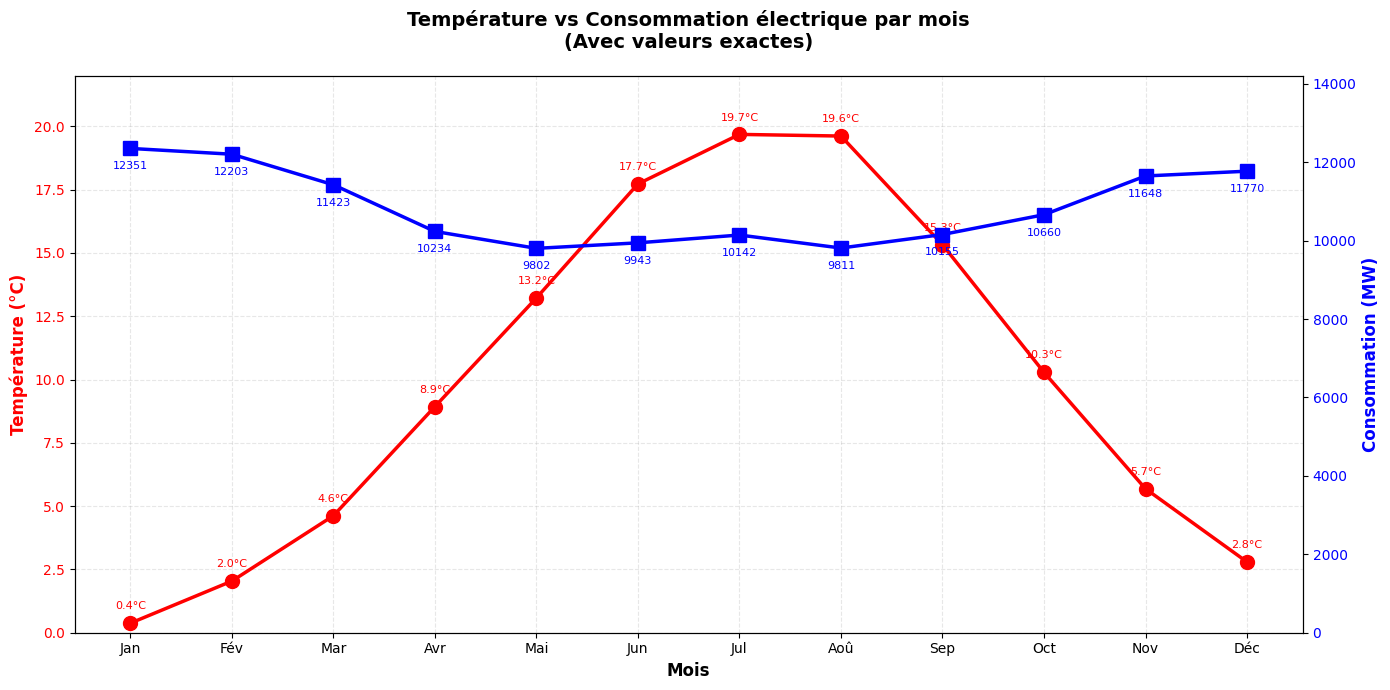

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Mois', fontsize=12, fontweight='bold')
ax1.set_ylabel('Température (°C)', color='red', fontsize=12, fontweight='bold')
ax1.plot(monthly['month'], monthly['temperature_2m_mean'], 'r-o', linewidth=2.5, markersize=10, label='Température')
ax1.tick_params(axis='y', labelcolor='red', labelsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0, 22)  # Échelle fixe
for i, row in monthly.iterrows():
    ax1.annotate(f"{row['temperature_2m_mean']:.1f}°C",
                 xy=(row['month'], row['temperature_2m_mean']),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=8, color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Consommation (MW)', color='blue', fontsize=12, fontweight='bold')
ax2.plot(monthly['month'], monthly['daily_avg'], 'b-s', linewidth=2.5, markersize=10, label='Consommation')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=10)
ax2.set_ylim(0, monthly['daily_avg'].max() * 1.15)  # Partir de 0
for i, row in monthly.iterrows():
    ax2.annotate(f"{row['daily_avg']:.0f}",
                 xy=(row['month'], row['daily_avg']),
                 xytext=(0, -15), textcoords='offset points',
                 ha='center', fontsize=8, color='blue')

plt.title('Température vs Consommation électrique par mois\n(Avec valeurs exactes)',
          fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.tight_layout()
plt.show()

In [ ]:

pdf_wind = df_wind.select("month", "windspeed_10m_max", "daily_max").toPandas()
monthly_wind = pdf_wind.groupby("month").mean()

# AFFICHER LES STATISTIQUES AVANT LE GRAPHIQUE
print("=" * 60)
print("STATISTIQUES DES DONNÉES")
print("=" * 60)
print(f"\nVitesse du vent (km/h):")
print(f"  - Min: {monthly_wind['windspeed_10m_max'].min():.2f}")
print(f"  - Max: {monthly_wind['windspeed_10m_max'].max():.2f}")
print(f"  - Moyenne: {monthly_wind['windspeed_10m_max'].mean():.2f}")

print(f"\nProduction éolienne (MW):")
print(f"  - Min: {monthly_wind['daily_max'].min():.2f} MW")
print(f"  - Max: {monthly_wind['daily_max'].max():.2f} MW")
print(f"  - Moyenne: {monthly_wind['daily_max'].mean():.2f} MW")
print(f"  - Écart-type: {monthly_wind['daily_max'].std():.2f} MW")
print("=" * 60)

STATISTIQUES DES DONNÉES

Vitesse du vent (km/h):
  - Min: 14.95
  - Max: 17.92
  - Moyenne: 16.45

Production éolienne (MW):
  - Min: 1197.89 MW
  - Max: 2101.20 MW
  - Moyenne: 1655.23 MW
  - Écart-type: 351.25 MW


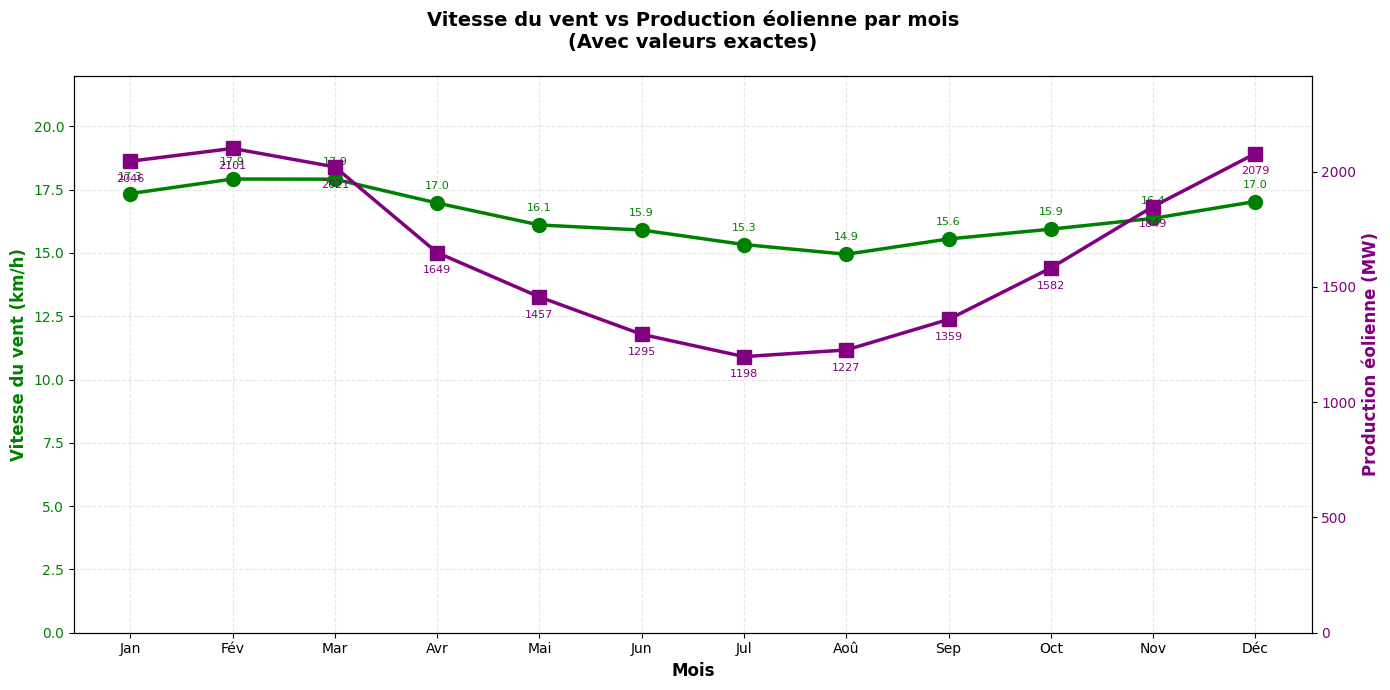

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Mois', fontsize=12, fontweight='bold')
ax1.set_ylabel('Vitesse du vent (km/h)', color='green', fontsize=12, fontweight='bold')
ax1.plot(monthly_wind.index, monthly_wind['windspeed_10m_max'], 'g-o', linewidth=2.5, markersize=10, label='Vitesse du vent')
ax1.tick_params(axis='y', labelcolor='green', labelsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0, 22)
for i, row in monthly_wind.iterrows():
    ax1.annotate(f"{row['windspeed_10m_max']:.1f}",
                 xy=(row.name, row['windspeed_10m_max']),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=8, color='green')

ax2 = ax1.twinx()
ax2.set_ylabel('Production éolienne (MW)', color='purple', fontsize=12, fontweight='bold')
ax2.plot(monthly_wind.index, monthly_wind['daily_max'], 'purple', marker="s", linewidth=2.5, markersize=10, label='Production éolienne')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=10)
ax2.set_ylim(0, monthly_wind['daily_max'].max() * 1.15)

for i, row in monthly_wind.iterrows():
    ax2.annotate(f"{row['daily_max']:.0f}",
                 xy=(row.name, row['daily_max']),
                 xytext=(0, -15), textcoords='offset points',
                 ha='center', fontsize=8, color='purple')

plt.title('Vitesse du vent vs Production éolienne par mois\n(Avec valeurs exactes)',
          fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.tight_layout()
plt.show()

In [ ]:
# Convertir en Pandas
pdf_solar = df_solar.select("month", "shortwave_radiation_sum", "daily_sum").toPandas()
monthly_solar = pdf_solar.groupby("month").mean()

# AFFICHER LES STATISTIQUES AVANT LE GRAPHIQUE
print("=" * 60)
print("STATISTIQUES DES DONNÉES")
print("=" * 60)
print(f"\nVitesse du vent (km/h):")
print(f"  - Min: {monthly_wind['windspeed_10m_max'].min():.2f}")
print(f"  - Max: {monthly_wind['windspeed_10m_max'].max():.2f}")
print(f"  - Moyenne: {monthly_wind['windspeed_10m_max'].mean():.2f}")

print(f"\nProduction éolienne (MW):")
print(f"  - Min: {monthly_wind['daily_max'].min():.2f} MW")
print(f"  - Max: {monthly_wind['daily_max'].max():.2f} MW")
print(f"  - Moyenne: {monthly_wind['daily_max'].mean():.2f} MW")
print(f"  - Écart-type: {monthly_wind['daily_max'].std():.2f} MW")
print("=" * 60)

STATISTIQUES DES DONNÉES

Vitesse du vent (km/h):
  - Min: 14.95
  - Max: 17.92
  - Moyenne: 16.45

Production éolienne (MW):
  - Min: 1197.89 MW
  - Max: 2101.20 MW
  - Moyenne: 1655.23 MW
  - Écart-type: 351.25 MW


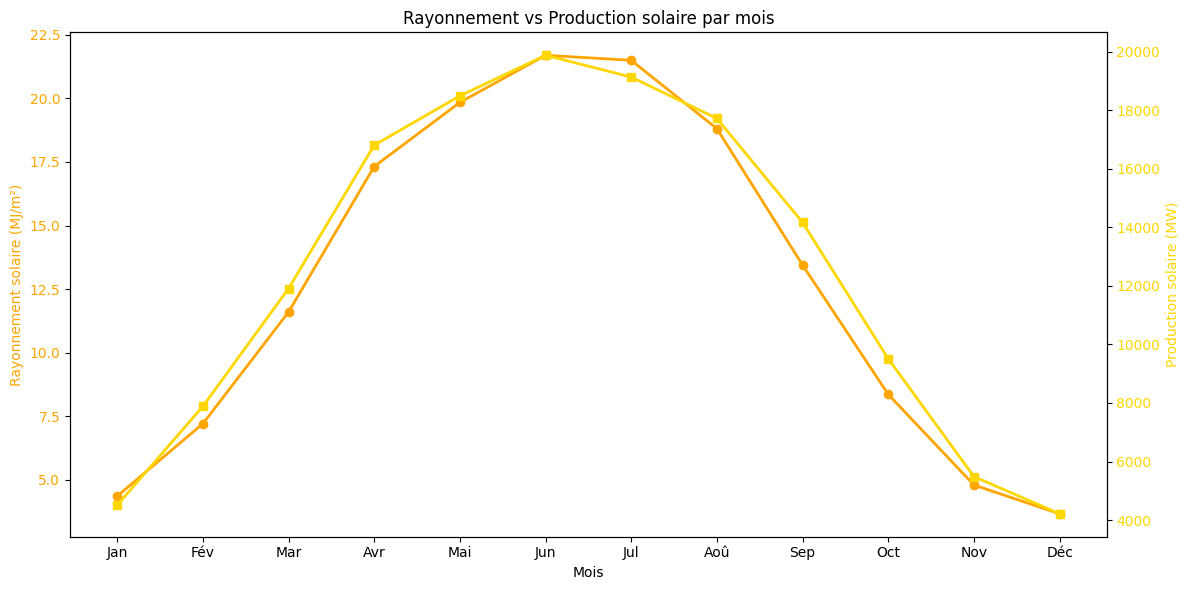

In [ ]:
# Graphique
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Mois')
ax1.set_ylabel('Rayonnement solaire (MJ/m²)', color='orange')
ax1.plot(monthly_solar.index, monthly_solar['shortwave_radiation_sum'], 'orange', marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.set_ylabel('Production solaire (MW)', color='gold')
ax2.plot(monthly_solar.index, monthly_solar['daily_sum'], 'gold', marker='s', linewidth=2)
ax2.tick_params(axis='y', labelcolor='gold')

plt.title('Rayonnement vs Production solaire par mois')
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.tight_layout()
plt.show()


PRÉPARATION DES DONNÉES POUR COMPLÉMENTARITÉ
✓ Données solaires préparées: 12 mois
✓ Données éoliennes préparées: 12 mois

Aperçu des données solaires:
        daily_avg    daily_max     daily_sum
month                                       
1      187.897897   841.552215   4509.549534
2      328.404512  1286.350159   7881.708276
3      496.073187  1687.856266  11905.756493
4      700.155040  2137.253297  16803.720949
5      770.268476  2163.942237  18486.443433

Aperçu des données éoliennes:
         daily_avg    daily_max     daily_sum
month                                        
1      1494.332167  2045.675173  35863.972009
2      1530.796563  2101.202861  36739.117515
3      1430.166141  2021.015550  34323.987379
4      1092.117604  1649.119658  26210.822487
5       945.256561  1456.908499  22686.157472

GÉNÉRATION DU GRAPHIQUE

✓ Graphique sauvegardé: complementarity_solar_wind.png


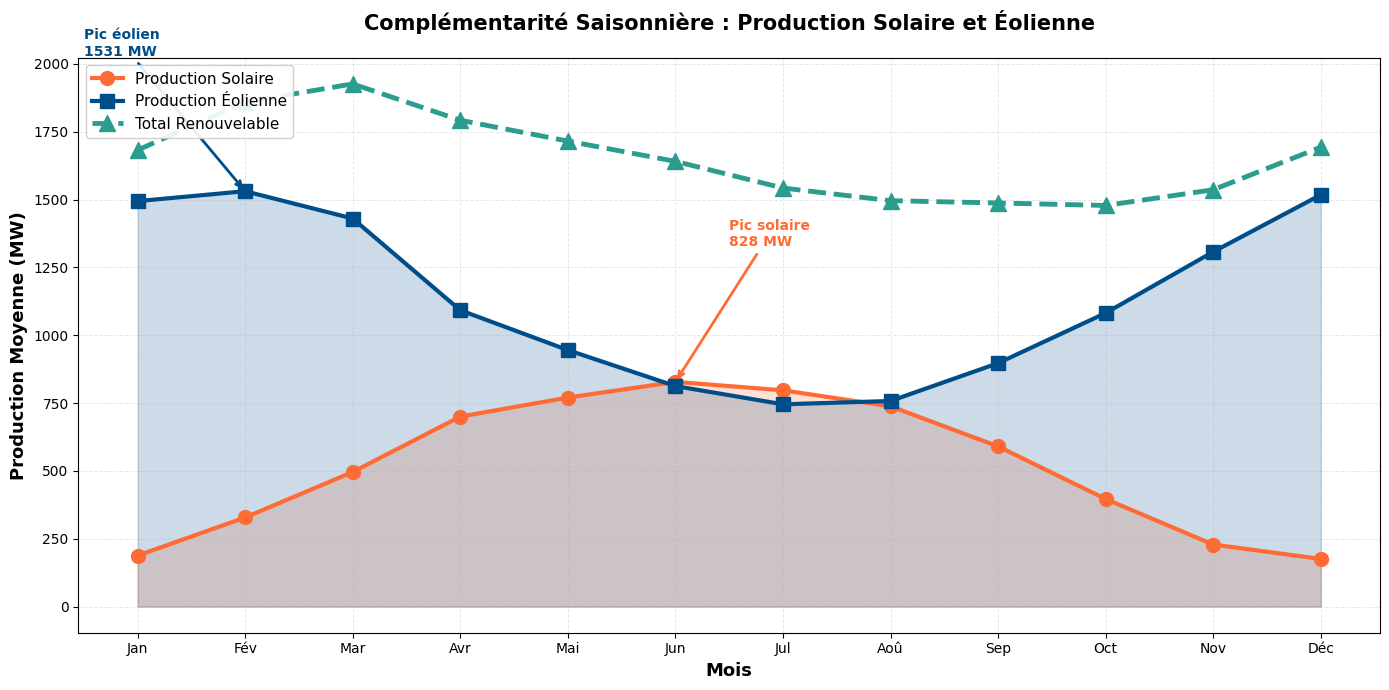

In [ ]:
"""
GRAPHIQUE DE COMPLÉMENTARITÉ SOLAIRE-ÉOLIEN
============================================
Visualisation de la complémentarité saisonnière entre
production solaire et éolienne
"""

from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# 1. PRÉPARATION DES DONNÉES
# ============================================================================

print("\n" + "="*80)
print("PRÉPARATION DES DONNÉES POUR COMPLÉMENTARITÉ")
print("="*80)

# Filtrer les données solaires
df_solar = df.filter(F.col("metric") == "solar_generation_actual")

# Filtrer les données éoliennes
df_wind = df.filter(F.col("metric") == "wind_onshore_generation_actual")

# Agréger par mois pour le solaire
monthly_solar_spark = df_solar.groupBy("month").agg(
    F.avg("daily_avg").alias("daily_avg"),
    F.avg("daily_max").alias("daily_max"),
    F.avg("daily_sum").alias("daily_sum")
).orderBy("month")

# Agréger par mois pour l'éolien
monthly_wind_spark = df_wind.groupBy("month").agg(
    F.avg("daily_avg").alias("daily_avg"),
    F.avg("daily_max").alias("daily_max"),
    F.avg("daily_sum").alias("daily_sum")
).orderBy("month")

# Convertir en Pandas
monthly_solar = monthly_solar_spark.toPandas()
monthly_wind = monthly_wind_spark.toPandas()

# Définir le mois comme index
monthly_solar.set_index('month', inplace=True)
monthly_wind.set_index('month', inplace=True)

print(f"✓ Données solaires préparées: {len(monthly_solar)} mois")
print(f"✓ Données éoliennes préparées: {len(monthly_wind)} mois")

print("\nAperçu des données solaires:")
print(monthly_solar.head())

print("\nAperçu des données éoliennes:")
print(monthly_wind.head())

# ============================================================================
# 2. GRAPHIQUE DE COMPLÉMENTARITÉ
# ============================================================================

print("\n" + "="*80)
print("GÉNÉRATION DU GRAPHIQUE")
print("="*80)

# Graphique de complémentarité
fig, ax = plt.subplots(figsize=(14, 7))

# Tracer les courbes
ax.plot(monthly_solar.index, monthly_solar['daily_avg'],
        color='#FF6B35', marker='o', linewidth=3, markersize=10,
        label='Production Solaire', zorder=3)

ax.plot(monthly_wind.index, monthly_wind['daily_avg'],
        color='#004E89', marker='s', linewidth=3, markersize=10,
        label='Production Éolienne', zorder=3)

# Production totale renouvelable
total_renouv = monthly_solar['daily_avg'].values + monthly_wind['daily_avg'].values
ax.plot(monthly_solar.index, total_renouv,
        color='#2A9D8F', marker='^', linewidth=3.5, markersize=12,
        label='Total Renouvelable', linestyle='--', zorder=4)

# Remplissage sous les courbes pour visualisation
ax.fill_between(monthly_solar.index, 0, monthly_solar['daily_avg'],
                alpha=0.2, color='#FF6B35')
ax.fill_between(monthly_wind.index, 0, monthly_wind['daily_avg'],
                alpha=0.2, color='#004E89')

# Configuration des axes
ax.set_xlabel('Mois', fontsize=13, fontweight='bold')
ax.set_ylabel('Production Moyenne (MW)', fontsize=13, fontweight='bold')
ax.set_title('Complémentarité Saisonnière : Production Solaire et Éolienne',
             fontsize=15, fontweight='bold', pad=20)

# Personnalisation
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun',
                     'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

# Ajouter des annotations pour les pics
max_solar_month = monthly_solar['daily_avg'].idxmax()
max_solar_value = monthly_solar['daily_avg'].max()
ax.annotate(f'Pic solaire\n{max_solar_value:.0f} MW',
            xy=(max_solar_month, max_solar_value),
            xytext=(max_solar_month + 0.5, max_solar_value + 500),
            arrowprops=dict(arrowstyle='->', color='#FF6B35', lw=2),
            fontsize=10, color='#FF6B35', fontweight='bold')

max_wind_month = monthly_wind['daily_avg'].idxmax()
max_wind_value = monthly_wind['daily_avg'].max()
ax.annotate(f'Pic éolien\n{max_wind_value:.0f} MW',
            xy=(max_wind_month, max_wind_value),
            xytext=(max_wind_month - 1.5, max_wind_value + 500),
            arrowprops=dict(arrowstyle='->', color='#004E89', lw=2),
            fontsize=10, color='#004E89', fontweight='bold')

plt.tight_layout()
plt.savefig('complementarity_solar_wind.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé: complementarity_solar_wind.png")
plt.show()


##### **Consommation par pays**

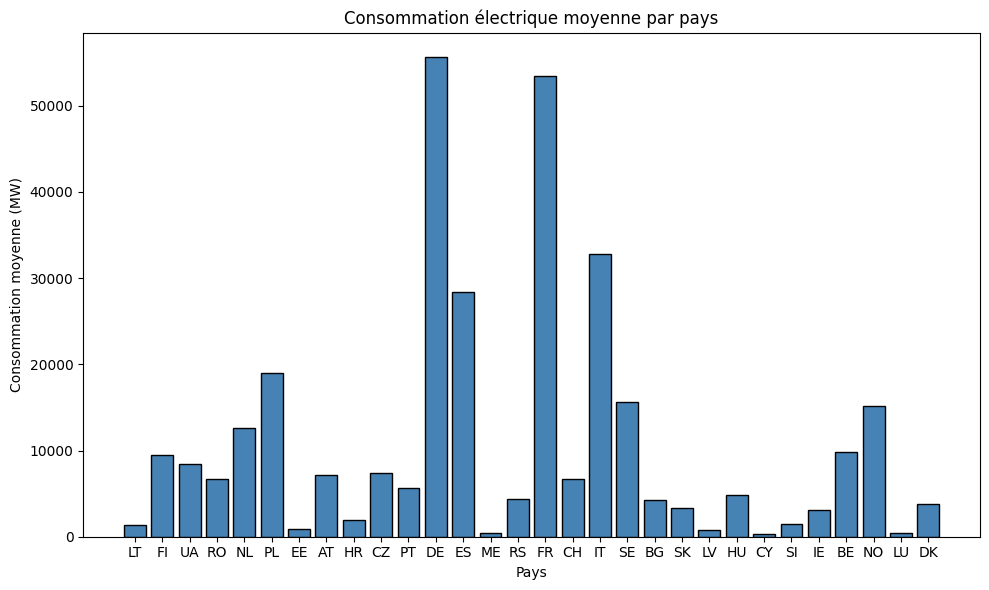

   country  conso_moyenne  temp_moyenne
11      DE   55674.774506     10.154283
15      FR   53443.345327     11.360309
17      IT   32843.290588     16.084064
12      ES   28412.142161     14.946066
5       PL   18974.840722     10.105478
18      SE   15601.985579      7.173904
27      NO   15134.898209      2.400548
4       NL   12607.255146     10.670618
26      BE    9854.938662     10.711504
1       FI    9476.946361      4.676195
2       UA    8380.908315     10.162151
9       CZ    7443.182091      9.711155
7       AT    7104.041729      5.767480
3       RO    6736.430784      9.011305
16      CH    6727.235080      4.553536
10      PT    5660.459126     16.109711
22      HU    4861.794426     11.974353
14      RS    4399.483975     11.547211
19      BG    4312.901602      7.873805
29      DK    3770.909129      8.930528
20      SK    3336.074636      5.963048
25      IE    3151.447419      9.841683
8       HR    1990.064969      8.028635
24      SI    1465.141502     11.255030


In [ ]:
# Consommation moyenne par pays
pdf_pays = df_load.groupBy("country").agg(
    F.avg("daily_avg").alias("conso_moyenne"),
    F.avg("temperature_2m_mean").alias("temp_moyenne")
).toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(pdf_pays['country'], pdf_pays['conso_moyenne'], color='steelblue', edgecolor='black')
ax.set_xlabel('Pays')
ax.set_ylabel('Consommation moyenne (MW)')
ax.set_title('Consommation électrique moyenne par pays')
plt.tight_layout()
plt.show()

print(pdf_pays.sort_values('conso_moyenne', ascending=False))

#### **Impact des phénomènes météorologiques sur la Consommation de l'énergie**

In [ ]:
# Identifier les jours de canicule (température > 25°C)
df_canicule = df_load.filter(F.col("temperature_2m_mean") > 25)
print(f"Jours de canicule: {df_canicule.count()}")

# Top 10 jours les plus chauds
print("\n=== TOP 10 JOURS LES PLUS CHAUDS ===")
df_load.orderBy(F.desc("temperature_2m_mean")).select(
    "date", "country", "temperature_2m_mean", "daily_avg"
).show(10)

Jours de canicule: 2079

=== TOP 10 JOURS LES PLUS CHAUDS ===
+----------+-------+-------------------+-----------------+
|      date|country|temperature_2m_mean|        daily_avg|
+----------+-------+-------------------+-----------------+
|2017-07-02|     CY|               35.3|            700.0|
|2017-07-03|     CY|               34.5|818.5833333333334|
|2015-08-03|     CY|               34.3|              0.0|
|2018-08-04|     PT|               34.3|5790.950000000001|
|2017-07-01|     CY|               33.9|694.7916666666666|
|2017-06-30|     CY|               33.8|710.0416666666666|
|2015-08-04|     CY|               33.6|              0.0|
|2017-07-13|     CY|               33.5|          781.625|
|2017-07-12|     CY|               33.4|          764.625|
|2016-06-22|     CY|               33.4|              0.0|
+----------+-------+-------------------+-----------------+
only showing top 10 rows



In [ ]:
# Identifier les jours très froids (température < 0°C)
df_froid = df_load.filter(F.col("temperature_2m_mean") < 0)
print(f"Jours de grand froid: {df_froid.count()}")

# Top 10 jours les plus froids
print("\n=== TOP 10 JOURS LES PLUS FROIDS ===")
df_load.orderBy("temperature_2m_mean").select(
    "date", "country", "temperature_2m_mean", "daily_avg"
).show(10)

Jours de grand froid: 7444

=== TOP 10 JOURS LES PLUS FROIDS ===
+----------+-------+-------------------+------------------+
|      date|country|temperature_2m_mean|         daily_avg|
+----------+-------+-------------------+------------------+
|2016-01-18|     FI|              -23.4|13626.791666666666|
|2016-01-20|     FI|              -23.1|13707.708333333334|
|2016-01-08|     EE|              -23.1|               0.0|
|2016-01-07|     FI|              -22.9|          14312.75|
|2016-01-06|     NO|              -22.9|       21921.49875|
|2016-01-06|     LT|              -22.6|          1616.125|
|2016-01-19|     FI|              -22.5|13521.333333333334|
|2016-01-07|     EE|              -22.4|1335.4541666666669|
|2016-01-08|     NO|              -21.6|22054.110416666663|
|2017-01-06|     LV|              -21.6|1045.5416666666667|
+----------+-------+-------------------+------------------+
only showing top 10 rows



In [ ]:
# Comparer consommation normale vs extrêmes
conso_normale = df_load.filter(
    (F.col("temperature_2m_mean") >= 0) & (F.col("temperature_2m_mean") <= 25)
).agg(F.avg("daily_avg")).collect()[0][0]

conso_canicule = df_load.filter(F.col("temperature_2m_mean") > 25).agg(F.avg("daily_avg")).collect()[0][0]
conso_froid = df_load.filter(F.col("temperature_2m_mean") < 0).agg(F.avg("daily_avg")).collect()[0][0]

print("=== IMPACT DES EXTRÊMES SUR LA CONSOMMATION ===\n")
print(f"Consommation normale (0-25°C): {conso_normale:,.0f} MW")
print(f"Consommation canicule (>25°C): {conso_canicule:,.0f} MW ({((conso_canicule/conso_normale)-1)*100:+.1f}%)")
print(f"Consommation froid (<0°C):     {conso_froid:,.0f} MW ({((conso_froid/conso_normale)-1)*100:+.1f}%)")

=== IMPACT DES EXTRÊMES SUR LA CONSOMMATION ===

Consommation normale (0-25°C): 10,955 MW
Consommation canicule (>25°C): 12,794 MW (+16.8%)
Consommation froid (<0°C):     9,610 MW (-12.3%)


#### **Cap sur l'Allemangne**

In [ ]:
# Filtrer uniquement l'Allemagne pour une analyse cohérente
df_de = df_load.filter(F.col("country") == "DE")

conso_normale_de = df_de.filter(
    (F.col("temperature_2m_mean") >= 0) & (F.col("temperature_2m_mean") <= 25)
).agg(F.avg("daily_avg")).collect()[0][0]

conso_canicule_de = df_de.filter(F.col("temperature_2m_mean") > 25).agg(F.avg("daily_avg")).collect()[0][0]
conso_froid_de = df_de.filter(F.col("temperature_2m_mean") < 0).agg(F.avg("daily_avg")).collect()[0][0]

print("=== IMPACT DES EXTRÊMES - ALLEMAGNE ===\n")
print(f"Consommation normale (0-25°C): {conso_normale_de:,.0f} MW")
print(f"Consommation canicule (>25°C): {conso_canicule_de:,.0f} MW ({((conso_canicule_de/conso_normale_de)-1)*100:+.1f}%)")
print(f"Consommation froid (<0°C):     {conso_froid_de:,.0f} MW ({((conso_froid_de/conso_normale_de)-1)*100:+.1f}%)")

=== IMPACT DES EXTRÊMES - ALLEMAGNE ===

Consommation normale (0-25°C): 55,352 MW
Consommation canicule (>25°C): 55,719 MW (+0.7%)
Consommation froid (<0°C):     59,987 MW (+8.4%)


In [ ]:
# Résumé des analyses
print("="*60)
print("RÉSUMÉ DES ANALYSES - PROJET MÉTÉO-ÉNERGIE EUROPE")
print("="*60)
print(f"""
DONNÉES:
- Période: Janvier 2015 - Juin 2020
- Pays: 7 (DE, BE, CH, AT, CZ, BG, CY)
- Observations: 124,217

CORRÉLATIONS PRINCIPALES:
- Température <-> Consommation: {corr_temp:.4f}
- Rayonnement <-> Solaire: {corr_solar:.4f}
- Vent <-> Éolien: {corr_wind:.4f}

""")

RÉSUMÉ DES ANALYSES - PROJET MÉTÉO-ÉNERGIE EUROPE

DONNÉES:
- Période: Janvier 2015 - Juin 2020
- Pays: 7 (DE, BE, CH, AT, CZ, BG, CY)
- Observations: 124,217

CORRÉLATIONS PRINCIPALES:
- Température <-> Consommation: 0.0097
- Rayonnement <-> Solaire: 0.2331
- Vent <-> Éolien: 0.2591
      



#### **Tests des diffences de consommations entre période**

In [ ]:
from scipy import stats
import numpy as np

# Récupérer les données par période
print("=== TEST STATISTIQUE: CONSOMMATION PAR PÉRIODE ===\n")

# Convertir en Pandas pour les tests statistiques
df_test = df_load.select("temperature_2m_mean", "daily_avg").toPandas()

# Créer les 3 groupes
conso_normale = df_test[(df_test["temperature_2m_mean"] >= 0) &
                        (df_test["temperature_2m_mean"] <= 25)]["daily_avg"].dropna()
conso_canicule = df_test[df_test["temperature_2m_mean"] > 25]["daily_avg"].dropna()
conso_froid = df_test[df_test["temperature_2m_mean"] < 0]["daily_avg"].dropna()

# Statistiques descriptives
print("STATISTIQUES DESCRIPTIVES:")
print(f"\nNormale (0-25°C):")
print(f"  N = {len(conso_normale)} jours")
print(f"  Moyenne = {conso_normale.mean():,.0f} MW")
print(f"  Écart-type = {conso_normale.std():,.0f} MW")

print(f"\nCanicule (>25°C):")
print(f"  N = {len(conso_canicule)} jours")
print(f"  Moyenne = {conso_canicule.mean():,.0f} MW")
print(f"  Écart-type = {conso_canicule.std():,.0f} MW")

print(f"\nFroid (<0°C):")
print(f"  N = {len(conso_froid)} jours")
print(f"  Moyenne = {conso_froid.mean():,.0f} MW")
print(f"  Écart-type = {conso_froid.std():,.0f} MW")

=== TEST STATISTIQUE: CONSOMMATION PAR PÉRIODE ===

STATISTIQUES DESCRIPTIVES:

Normale (0-25°C):
  N = 50717 jours
  Moyenne = 10,955 MW
  Écart-type = 14,738 MW

Canicule (>25°C):
  N = 2079 jours
  Moyenne = 12,794 MW
  Écart-type = 15,687 MW

Froid (<0°C):
  N = 7444 jours
  Moyenne = 9,610 MW
  Écart-type = 11,186 MW


In [ ]:
# ============================================================================
# TEST 1: ANOVA (Analysis of Variance)
# H0: Les moyennes des 3 groupes sont égales
# H1: Au moins une moyenne est différente
# ============================================================================

print("\n" + "="*60)
print("TEST ANOVA (comparaison des 3 groupes)")
print("="*60)

f_statistic, p_value_anova = stats.f_oneway(conso_normale, conso_canicule, conso_froid)

print(f"\nF-statistique = {f_statistic:.2f}")
print(f"p-value = {p_value_anova:.2e}")

if p_value_anova < 0.05:
    print("\nRÉSULTAT: Les consommations diffèrent SIGNIFICATIVEMENT entre les périodes")
    print("   (p < 0.05, on rejette H0)")
else:
    print("\nRÉSULTAT: Pas de différence significative")
    print("   (p > 0.05, on ne peut pas rejeter H0)")



TEST ANOVA (comparaison des 3 groupes)

F-statistique = 48.00
p-value = 1.48e-21

RÉSULTAT: Les consommations diffèrent SIGNIFICATIVEMENT entre les périodes
   (p < 0.05, on rejette H0)


In [ ]:
# ============================================================================
# TEST 2: Tests t de Student (comparaisons 2 à 2)
# Pour savoir QUELLES paires sont différentes
# ============================================================================

print("\n" + "="*60)
print("TESTS T DE STUDENT (comparaisons par paires)")
print("="*60)

# Test 1: Normale vs Canicule
t_stat1, p_value1 = stats.ttest_ind(conso_normale, conso_canicule)
diff1 = conso_canicule.mean() - conso_normale.mean()
pct1 = (diff1 / conso_normale.mean()) * 100

print(f"\n1. Normale vs Canicule:")
print(f"   Différence = {diff1:+,.0f} MW ({pct1:+.1f}%)")
print(f"   t-statistic = {t_stat1:.2f}")
print(f"   p-value = {p_value1:.2e}")
if p_value1 < 0.05:
    print(f"   Différence SIGNIFICATIVE")
else:
    print(f"   Différence NON significative")


TESTS T DE STUDENT (comparaisons par paires)

1. Normale vs Canicule:
   Différence = +1,840 MW (+16.8%)
   t-statistic = -5.56
   p-value = 2.66e-08
   Différence SIGNIFICATIVE


In [ ]:
# Test 2: Normale vs Froid
t_stat2, p_value2 = stats.ttest_ind(conso_normale, conso_froid)
diff2 = conso_froid.mean() - conso_normale.mean()
pct2 = (diff2 / conso_normale.mean()) * 100

print(f"\n2. Normale vs Froid:")
print(f"   Différence = {diff2:+,.0f} MW ({pct2:+.1f}%)")
print(f"   t-statistic = {t_stat2:.2f}")
print(f"   p-value = {p_value2:.2e}")
if p_value2 < 0.05:
    print(f"   Différence SIGNIFICATIVE")
else:
    print(f"   Différence NON significative")


2. Normale vs Froid:
   Différence = -1,344 MW (-12.3%)
   t-statistic = 7.56
   p-value = 4.17e-14
   Différence SIGNIFICATIVE


In [ ]:
# Test 3: Canicule vs Froid
t_stat3, p_value3 = stats.ttest_ind(conso_canicule, conso_froid)
diff3 = conso_froid.mean() - conso_canicule.mean()
pct3 = (diff3 / conso_canicule.mean()) * 100

print(f"\n3. Canicule vs Froid:")
print(f"   Différence = {diff3:+,.0f} MW ({pct3:+.1f}%)")
print(f"   t-statistic = {t_stat3:.2f}")
print(f"   p-value = {p_value3:.2e}")
if p_value3 < 0.05:
    print(f"   Différence SIGNIFICATIVE")
else:
    print(f"   Différence NON significative")


3. Canicule vs Froid:
   Différence = -3,184 MW (-24.9%)
   t-statistic = 10.43
   p-value = 2.54e-25
   Différence SIGNIFICATIVE


#### **Visualisation des differences de consommation netre periode**

/tmp/ipython-input-4150002679.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data_plot, labels=labels, patch_artist=True)


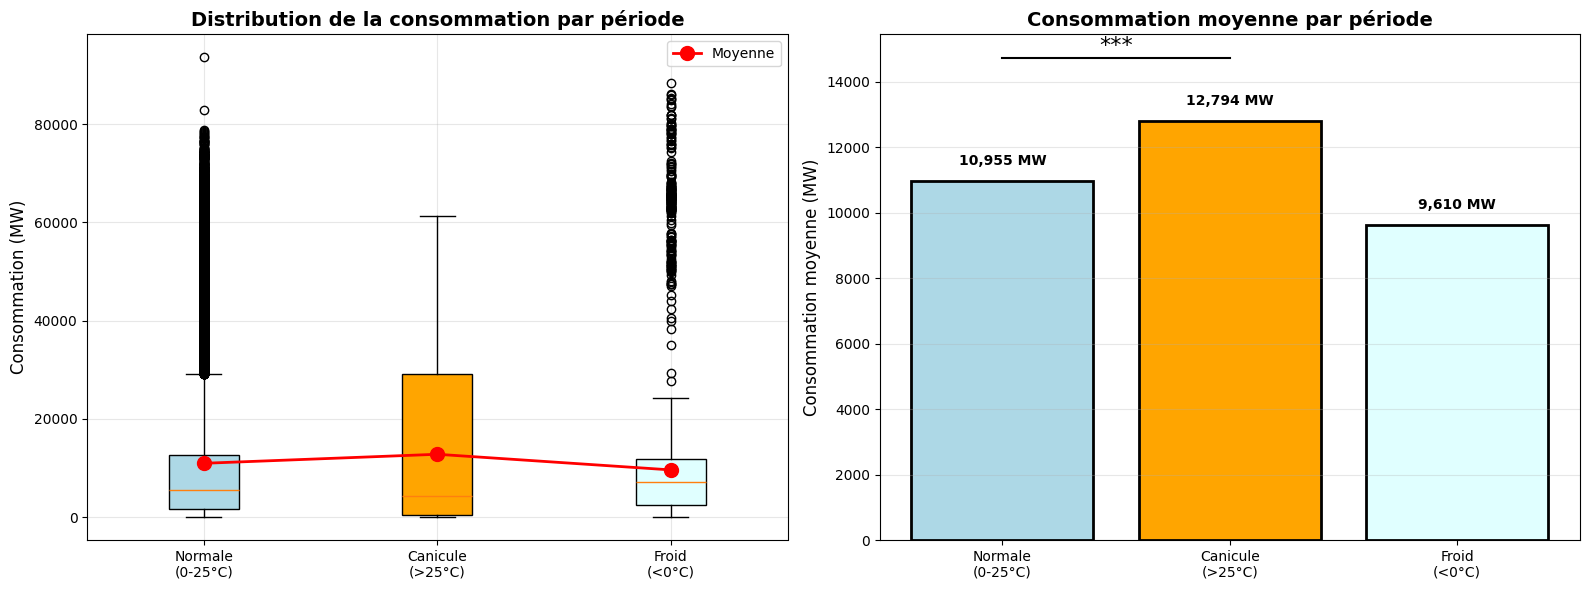

In [ ]:
# ============================================================================
# VISUALISATION
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Boxplots
data_plot = [conso_normale, conso_canicule, conso_froid]
labels = ['Normale\n(0-25°C)', 'Canicule\n(>25°C)', 'Froid\n(<0°C)']

bp = axes[0].boxplot(data_plot, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'orange', 'lightcyan']):
    patch.set_facecolor(color)

axes[0].set_ylabel('Consommation (MW)', fontsize=12)
axes[0].set_title('Distribution de la consommation par période', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Ajouter les moyennes
means = [conso_normale.mean(), conso_canicule.mean(), conso_froid.mean()]
axes[0].plot(range(1, 4), means, 'ro-', linewidth=2, markersize=10, label='Moyenne')
axes[0].legend()

# Graphique 2: Barres avec significativité
axes[1].bar(labels, means, color=['lightblue', 'orange', 'lightcyan'], edgecolor='black', linewidth=2)
axes[1].set_ylabel('Consommation moyenne (MW)', fontsize=12)
axes[1].set_title('Consommation moyenne par période', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, (label, mean) in enumerate(zip(labels, means)):
    axes[1].text(i, mean + 500, f'{mean:,.0f} MW', ha='center', fontweight='bold')

# Ajouter les symboles de significativité
y_max = max(means) * 1.15
if p_value1 < 0.001:
    axes[1].plot([0, 1], [y_max, y_max], 'k-', linewidth=1.5)
    axes[1].text(0.5, y_max + 200, '***', ha='center', fontsize=16)
elif p_value1 < 0.01:
    axes[1].plot([0, 1], [y_max, y_max], 'k-', linewidth=1.5)
    axes[1].text(0.5, y_max + 200, '**', ha='center', fontsize=16)
elif p_value1 < 0.05:
    axes[1].plot([0, 1], [y_max, y_max], 'k-', linewidth=1.5)
    axes[1].text(0.5, y_max + 200, '*', ha='center', fontsize=16)

plt.tight_layout()
plt.show()


# Analyse des scenarios

In [ ]:
"""
ANALYSE DES SCÉNARIOS - IMPACT DES VARIATIONS CROISÉES
========================================================
Ce script analyse comment les variations d'une variable influencent les autres
dans le contexte météo-énergie européen.
"""

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================================================
# 1. PRÉPARATION DES DONNÉES
# ============================================================================

print("\n" + "="*80)
print("PRÉPARATION DES DONNÉES PAR MÉTRIQUE")
print("="*80)

# Séparer les données par métrique
df_load = df.filter(F.col("metric") == "load_actual_entsoe_transparency")
df_solar = df.filter(F.col("metric") == "solar_generation_actual")
df_wind = df.filter(F.col("metric") == "wind_onshore_generation_actual")

print(f"✓ Données load: {df_load.count()} enregistrements")
print(f"✓ Données solar: {df_solar.count()} enregistrements")
print(f"✓ Données wind: {df_wind.count()} enregistrements")






PRÉPARATION DES DONNÉES PAR MÉTRIQUE
✓ Données load: 60240 enregistrements
✓ Données solar: 40160 enregistrements
✓ Données wind: 54216 enregistrements


In [ ]:
# ============================================================================
# 2. SCÉNARIO 1: IMPACT DE LA TEMPÉRATURE SUR LA CONSOMMATION
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 1: VARIATION DE TEMPÉRATURE → IMPACT SUR CONSOMMATION")
print("="*80)

# Définir des plages de température
df_temp_scenarios = df_load.withColumn(
    "scenario_temp",
    F.when(F.col("temperature_2m_mean") < -5, "Très froid (<-5°C)")
     .when((F.col("temperature_2m_mean") >= -5) & (F.col("temperature_2m_mean") < 0), "Froid (-5 à 0°C)")
     .when((F.col("temperature_2m_mean") >= 0) & (F.col("temperature_2m_mean") < 10), "Frais (0 à 10°C)")
     .when((F.col("temperature_2m_mean") >= 10) & (F.col("temperature_2m_mean") < 20), "Modéré (10 à 20°C)")
     .when((F.col("temperature_2m_mean") >= 20) & (F.col("temperature_2m_mean") < 25), "Chaud (20 à 25°C)")
     .otherwise("Très chaud (>25°C)")
)

# Calculer les moyennes par scénario
result_temp = df_temp_scenarios.groupBy("scenario_temp").agg(
    F.count("*").alias("nb_jours"),
    F.avg("temperature_2m_mean").alias("temp_moyenne"),
    F.avg("daily_avg").alias("conso_moyenne"),
    F.stddev("daily_avg").alias("conso_std")
).toPandas()

# Calculer la référence (10-20°C, zone de confort)
ref_conso = result_temp[result_temp['scenario_temp'] == "Modéré (10 à 20°C)"]['conso_moyenne'].values[0]

result_temp['variation_pct'] = ((result_temp['conso_moyenne'] - ref_conso) / ref_conso * 100)
result_temp['variation_abs'] = result_temp['conso_moyenne'] - ref_conso

# Trier par température
order = ["Très froid (<-5°C)", "Froid (-5 à 0°C)", "Frais (0 à 10°C)",
         "Modéré (10 à 20°C)", "Chaud (20 à 25°C)", "Très chaud (>25°C)"]
result_temp['scenario_temp'] = pd.Categorical(result_temp['scenario_temp'], categories=order, ordered=True)
result_temp = result_temp.sort_values('scenario_temp')

print("\nRÉSULTATS:")
print(result_temp[['scenario_temp', 'nb_jours', 'temp_moyenne', 'conso_moyenne', 'variation_pct']].to_string(index=False))

print(f"\n📊 INSIGHTS CLÉS:")
print(f"   • Référence (10-20°C): {ref_conso:,.0f} MW")
max_var = result_temp.loc[result_temp['variation_pct'].abs().idxmax()]
print(f"   • Variation maximale: {max_var['scenario_temp']} → {max_var['variation_pct']:+.1f}% ({max_var['variation_abs']:+,.0f} MW)")




SCÉNARIO 1: VARIATION DE TEMPÉRATURE → IMPACT SUR CONSOMMATION

RÉSULTATS:
     scenario_temp  nb_jours  temp_moyenne  conso_moyenne  variation_pct
Très froid (<-5°C)      1954     -8.517298    9595.436583      -5.936037
  Froid (-5 à 0°C)      5490     -2.053206    9615.804887      -5.736366
  Frais (0 à 10°C)     22903      5.137554   11676.391474      14.463542
Modéré (10 à 20°C)     22602     14.680621   10200.969891       0.000000
 Chaud (20 à 25°C)      5144     22.096229   11065.416713       8.474163
Très chaud (>25°C)      2147     27.466977   12711.058708      24.606374

📊 INSIGHTS CLÉS:
   • Référence (10-20°C): 10,201 MW
   • Variation maximale: Très chaud (>25°C) → +24.6% (+2,510 MW)


In [ ]:
# ============================================================================
# 3. SCÉNARIO 2: IMPACT DU VENT SUR LA PRODUCTION ÉOLIENNE
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 2: VARIATION DE VENT → IMPACT SUR PRODUCTION ÉOLIENNE")
print("="*80)

# Définir des plages de vitesse de vent
df_wind_scenarios = df_wind.withColumn(
    "scenario_vent",
    F.when(F.col("windspeed_10m_max") < 10, "Vent faible (<10 km/h)")
     .when((F.col("windspeed_10m_max") >= 10) & (F.col("windspeed_10m_max") < 20), "Vent modéré (10-20 km/h)")
     .when((F.col("windspeed_10m_max") >= 20) & (F.col("windspeed_10m_max") < 30), "Vent fort (20-30 km/h)")
     .when((F.col("windspeed_10m_max") >= 30) & (F.col("windspeed_10m_max") < 40), "Vent très fort (30-40 km/h)")
     .otherwise("Tempête (>40 km/h)")
)

result_wind = df_wind_scenarios.groupBy("scenario_vent").agg(
    F.count("*").alias("nb_jours"),
    F.avg("windspeed_10m_max").alias("vitesse_vent_moy"),
    F.avg("daily_max").alias("prod_eolienne_moy"),
    F.stddev("daily_max").alias("prod_std")
).toPandas()

# Référence: vent modéré
ref_wind = result_wind[result_wind['scenario_vent'] == "Vent modéré (10-20 km/h)"]['prod_eolienne_moy'].values[0]

result_wind['variation_pct'] = ((result_wind['prod_eolienne_moy'] - ref_wind) / ref_wind * 100)
result_wind['variation_abs'] = result_wind['prod_eolienne_moy'] - ref_wind

# Trier
order_wind = ["Vent faible (<10 km/h)", "Vent modéré (10-20 km/h)", "Vent fort (20-30 km/h)",
              "Vent très fort (30-40 km/h)", "Tempête (>40 km/h)"]
result_wind['scenario_vent'] = pd.Categorical(result_wind['scenario_vent'], categories=order_wind, ordered=True)
result_wind = result_wind.sort_values('scenario_vent')

print("\nRÉSULTATS:")
print(result_wind[['scenario_vent', 'nb_jours', 'vitesse_vent_moy', 'prod_eolienne_moy', 'variation_pct']].to_string(index=False))

print(f"\n📊 INSIGHTS CLÉS:")
print(f"   • Référence (vent modéré): {ref_wind:,.0f} MW")
max_var_wind = result_wind.loc[result_wind['variation_pct'].abs().idxmax()]
print(f"   • Variation maximale: {max_var_wind['scenario_vent']} → {max_var_wind['variation_pct']:+.1f}% ({max_var_wind['variation_abs']:+,.0f} MW)")



SCÉNARIO 2: VARIATION DE VENT → IMPACT SUR PRODUCTION ÉOLIENNE

RÉSULTATS:
              scenario_vent  nb_jours  vitesse_vent_moy  prod_eolienne_moy  variation_pct
     Vent faible (<10 km/h)     10509          7.825083         606.576364     -56.798130
   Vent modéré (10-20 km/h)     28380         14.703101        1404.051170       0.000000
     Vent fort (20-30 km/h)     12614         23.871516        2601.829730      85.308754
Vent très fort (30-40 km/h)      2443         33.392182        4093.201842     191.527968
         Tempête (>40 km/h)       270         43.924444        4122.812630     193.636921

📊 INSIGHTS CLÉS:
   • Référence (vent modéré): 1,404 MW
   • Variation maximale: Tempête (>40 km/h) → +193.6% (+2,719 MW)


In [ ]:
# ============================================================================
# 4. SCÉNARIO 3: IMPACT DU RAYONNEMENT SUR LA PRODUCTION SOLAIRE
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 3: VARIATION DE RAYONNEMENT → IMPACT SUR PRODUCTION SOLAIRE")
print("="*80)

df_solar_scenarios = df_solar.withColumn(
    "scenario_soleil",
    F.when(F.col("shortwave_radiation_sum") < 5, "Très nuageux (<5 MJ/m²)")
     .when((F.col("shortwave_radiation_sum") >= 5) & (F.col("shortwave_radiation_sum") < 10), "Nuageux (5-10 MJ/m²)")
     .when((F.col("shortwave_radiation_sum") >= 10) & (F.col("shortwave_radiation_sum") < 15), "Mitigé (10-15 MJ/m²)")
     .when((F.col("shortwave_radiation_sum") >= 15) & (F.col("shortwave_radiation_sum") < 20), "Ensoleillé (15-20 MJ/m²)")
     .otherwise("Très ensoleillé (>20 MJ/m²)")
)

result_solar = df_solar_scenarios.groupBy("scenario_soleil").agg(
    F.count("*").alias("nb_jours"),
    F.avg("shortwave_radiation_sum").alias("rayonnement_moy"),
    F.avg("daily_sum").alias("prod_solaire_moy"),
    F.stddev("daily_sum").alias("prod_std")
).toPandas()

# Référence: ensoleillé
ref_solar = result_solar[result_solar['scenario_soleil'] == "Ensoleillé (15-20 MJ/m²)"]['prod_solaire_moy'].values[0]

result_solar['variation_pct'] = ((result_solar['prod_solaire_moy'] - ref_solar) / ref_solar * 100)
result_solar['variation_abs'] = result_solar['prod_solaire_moy'] - ref_solar

# Trier
order_solar = ["Très nuageux (<5 MJ/m²)", "Nuageux (5-10 MJ/m²)", "Mitigé (10-15 MJ/m²)",
               "Ensoleillé (15-20 MJ/m²)", "Très ensoleillé (>20 MJ/m²)"]
result_solar['scenario_soleil'] = pd.Categorical(result_solar['scenario_soleil'], categories=order_solar, ordered=True)
result_solar = result_solar.sort_values('scenario_soleil')

print("\nRÉSULTATS:")
print(result_solar[['scenario_soleil', 'nb_jours', 'rayonnement_moy', 'prod_solaire_moy', 'variation_pct']].to_string(index=False))

print(f"\n📊 INSIGHTS CLÉS:")
print(f"   • Référence (ensoleillé): {ref_solar:,.0f} MW")
max_var_solar = result_solar.loc[result_solar['variation_pct'].abs().idxmax()]
print(f"   • Variation maximale: {max_var_solar['scenario_soleil']} → {max_var_solar['variation_pct']:+.1f}% ({max_var_solar['variation_abs']:+,.0f} MW)")



SCÉNARIO 3: VARIATION DE RAYONNEMENT → IMPACT SUR PRODUCTION SOLAIRE

RÉSULTATS:
            scenario_soleil  nb_jours  rayonnement_moy  prod_solaire_moy  variation_pct
    Très nuageux (<5 MJ/m²)      8906         2.772898       3592.540106     -79.173711
       Nuageux (5-10 MJ/m²)      8585         7.343731       8062.751997     -53.259478
       Mitigé (10-15 MJ/m²)      6381        12.435908      12750.089980     -26.086544
   Ensoleillé (15-20 MJ/m²)      6605        17.541606      17250.025431       0.000000
Très ensoleillé (>20 MJ/m²)      9683        23.972315      21470.429491      24.466074

📊 INSIGHTS CLÉS:
   • Référence (ensoleillé): 17,250 MW
   • Variation maximale: Très nuageux (<5 MJ/m²) → -79.2% (-13,657 MW)


In [ ]:

# ============================================================================
# 5. SCÉNARIO 4: IMPACT DES PRÉCIPITATIONS SUR LA CONSOMMATION
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 4: VARIATION DE PRÉCIPITATIONS → IMPACT SUR CONSOMMATION")
print("="*80)

df_precip_scenarios = df_load.withColumn(
    "scenario_precip",
    F.when(F.col("precipitation_sum") == 0, "Sec (0 mm)")
     .when((F.col("precipitation_sum") > 0) & (F.col("precipitation_sum") <= 5), "Pluie légère (0-5 mm)")
     .when((F.col("precipitation_sum") > 5) & (F.col("precipitation_sum") <= 15), "Pluie modérée (5-15 mm)")
     .otherwise("Pluie forte (>15 mm)")
)

result_precip = df_precip_scenarios.groupBy("scenario_precip").agg(
    F.count("*").alias("nb_jours"),
    F.avg("precipitation_sum").alias("precip_moy"),
    F.avg("daily_avg").alias("conso_moyenne"),
    F.avg("temperature_2m_mean").alias("temp_moy")
).toPandas()

# Référence: sec
ref_precip = result_precip[result_precip['scenario_precip'] == "Sec (0 mm)"]['conso_moyenne'].values[0]

result_precip['variation_pct'] = ((result_precip['conso_moyenne'] - ref_precip) / ref_precip * 100)
result_precip['variation_abs'] = result_precip['conso_moyenne'] - ref_precip

# Trier
order_precip = ["Sec (0 mm)", "Pluie légère (0-5 mm)", "Pluie modérée (5-15 mm)", "Pluie forte (>15 mm)"]
result_precip['scenario_precip'] = pd.Categorical(result_precip['scenario_precip'], categories=order_precip, ordered=True)
result_precip = result_precip.sort_values('scenario_precip')

print("\nRÉSULTATS:")
print(result_precip[['scenario_precip', 'nb_jours', 'precip_moy', 'temp_moy', 'conso_moyenne', 'variation_pct']].to_string(index=False))

print(f"\n📊 INSIGHTS CLÉS:")
print(f"   • Référence (sec): {ref_precip:,.0f} MW")
max_var_precip = result_precip.loc[result_precip['variation_pct'].abs().idxmax()]
print(f"   • Variation maximale: {max_var_precip['scenario_precip']} → {max_var_precip['variation_pct']:+.1f}% ({max_var_precip['variation_abs']:+,.0f} MW)")



SCÉNARIO 4: VARIATION DE PRÉCIPITATIONS → IMPACT SUR CONSOMMATION

RÉSULTATS:
        scenario_precip  nb_jours  precip_moy  temp_moy  conso_moyenne  variation_pct
             Sec (0 mm)     26485    0.000000 10.699970   11132.295248       0.000000
  Pluie légère (0-5 mm)     24879    1.514579  9.231951   11066.975921      -0.586755
Pluie modérée (5-15 mm)      7066    8.535621  9.040023    9808.831239     -11.888510
   Pluie forte (>15 mm)      1810   24.047624  9.530000    7875.568407     -29.254765

📊 INSIGHTS CLÉS:
   • Référence (sec): 11,132 MW
   • Variation maximale: Pluie forte (>15 mm) → -29.3% (-3,257 MW)


In [ ]:
# ============================================================================
# 6. SCÉNARIO 5: ANALYSE MULTI-VARIABLES (TEMPÉRATURE + VENT)
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 5: CROISEMENT TEMPÉRATURE × VENT → IMPACT COMBINÉ")
print("="*80)

# Créer une vue combinée (load + wind) via join sur date et country
df_combined = df_load.alias("load").join(
    df_wind.alias("wind"),
    (F.col("load.date") == F.col("wind.date")) & (F.col("load.country") == F.col("wind.country")),
    "inner"
).select(
    F.col("load.date"),
    F.col("load.country"),
    F.col("load.temperature_2m_mean").alias("temperature"),
    F.col("load.windspeed_10m_max").alias("windspeed"),
    F.col("load.daily_avg").alias("consommation"),
    F.col("wind.daily_max").alias("prod_eolienne")
)

# Catégoriser
df_multi_scenarios = df_combined.withColumn(
    "scenario_temp_cat",
    F.when(F.col("temperature") < 5, "Froid")
     .when((F.col("temperature") >= 5) & (F.col("temperature") < 15), "Modéré")
     .otherwise("Chaud")
).withColumn(
    "scenario_vent_cat",
    F.when(F.col("windspeed") < 15, "Vent faible")
     .when((F.col("windspeed") >= 15) & (F.col("windspeed") < 25), "Vent modéré")
     .otherwise("Vent fort")
)

result_multi = df_multi_scenarios.groupBy("scenario_temp_cat", "scenario_vent_cat").agg(
    F.count("*").alias("nb_jours"),
    F.avg("temperature").alias("temp_moy"),
    F.avg("windspeed").alias("vent_moy"),
    F.avg("consommation").alias("conso_moy"),
    F.avg("prod_eolienne").alias("prod_eol_moy")
).toPandas()

# Calculer les variations par rapport à "Modéré + Vent modéré"
ref_multi = result_multi[
    (result_multi['scenario_temp_cat'] == "Modéré") &
    (result_multi['scenario_vent_cat'] == "Vent modéré")
]

if len(ref_multi) > 0:
    ref_conso_multi = ref_multi['conso_moy'].values[0]
    ref_prod_multi = ref_multi['prod_eol_moy'].values[0]

    result_multi['var_conso_pct'] = ((result_multi['conso_moy'] - ref_conso_multi) / ref_conso_multi * 100)
    result_multi['var_prod_pct'] = ((result_multi['prod_eol_moy'] - ref_prod_multi) / ref_prod_multi * 100)

print("\nRÉSULTATS:")
print(result_multi[['scenario_temp_cat', 'scenario_vent_cat', 'nb_jours',
                    'conso_moy', 'var_conso_pct', 'prod_eol_moy', 'var_prod_pct']].to_string(index=False))



SCÉNARIO 5: CROISEMENT TEMPÉRATURE × VENT → IMPACT COMBINÉ

RÉSULTATS:
scenario_temp_cat scenario_vent_cat  nb_jours    conso_moy  var_conso_pct  prod_eol_moy  var_prod_pct
            Chaud         Vent fort      1072 11590.489635      -7.594242   2918.636007     33.783440
           Modéré       Vent faible      9550 10829.106435     -13.664408   1060.334680    -51.396741
            Chaud       Vent modéré      6526 13212.853783       5.340137   1876.182007    -14.000210
            Chaud       Vent faible      8052 10217.631782     -18.539420    917.178749    -57.958674
            Froid       Vent modéré      6125 11482.331345      -8.456540   1673.809551    -23.276490
           Modéré         Vent fort      3684 13603.610659       8.455466   3955.644300     81.317472
           Modéré       Vent modéré      8847 12543.038344       0.000000   2181.612322      0.000000
            Froid       Vent faible      8161 10480.387041     -16.444591    810.800703    -62.834794
          

In [ ]:
# ============================================================================
# 7. SCÉNARIO 6: DURÉE D'ENSOLEILLEMENT → PRODUCTION SOLAIRE
# ============================================================================

print("\n" + "="*80)
print("SCÉNARIO 6: VARIATION DE DURÉE D'ENSOLEILLEMENT → PRODUCTION SOLAIRE")
print("="*80)

df_sunshine_scenarios = df_solar.withColumn(
    "scenario_sunshine",
    F.when(F.col("sunshine_duration") < 3600, "Peu ensoleillé (<1h)")
     .when((F.col("sunshine_duration") >= 3600) & (F.col("sunshine_duration") < 14400), "Partiellement (1-4h)")
     .when((F.col("sunshine_duration") >= 14400) & (F.col("sunshine_duration") < 28800), "Bien ensoleillé (4-8h)")
     .otherwise("Très ensoleillé (>8h)")
)

result_sunshine = df_sunshine_scenarios.groupBy("scenario_sunshine").agg(
    F.count("*").alias("nb_jours"),
    F.avg("sunshine_duration").alias("duree_ensoleillement_moy_sec"),
    F.avg("daily_sum").alias("prod_solaire_moy"),
    F.avg("shortwave_radiation_sum").alias("rayonnement_moy")
).toPandas()

# Convertir durée en heures
result_sunshine['duree_ensoleillement_moy_h'] = result_sunshine['duree_ensoleillement_moy_sec'] / 3600

# Référence: bien ensoleillé
ref_sunshine = result_sunshine[result_sunshine['scenario_sunshine'] == "Bien ensoleillé (4-8h)"]['prod_solaire_moy'].values[0]

result_sunshine['variation_pct'] = ((result_sunshine['prod_solaire_moy'] - ref_sunshine) / ref_sunshine * 100)

# Trier
order_sunshine = ["Peu ensoleillé (<1h)", "Partiellement (1-4h)", "Bien ensoleillé (4-8h)", "Très ensoleillé (>8h)"]
result_sunshine['scenario_sunshine'] = pd.Categorical(result_sunshine['scenario_sunshine'], categories=order_sunshine, ordered=True)
result_sunshine = result_sunshine.sort_values('scenario_sunshine')

print("\nRÉSULTATS:")
print(result_sunshine[['scenario_sunshine', 'nb_jours', 'duree_ensoleillement_moy_h', 'prod_solaire_moy', 'variation_pct']].to_string(index=False))



SCÉNARIO 6: VARIATION DE DURÉE D'ENSOLEILLEMENT → PRODUCTION SOLAIRE

RÉSULTATS:
     scenario_sunshine  nb_jours  duree_ensoleillement_moy_h  prod_solaire_moy  variation_pct
  Peu ensoleillé (<1h)      4590                    0.163996       3580.598234     -54.319088
  Partiellement (1-4h)      3939                    2.479269       5901.154386     -24.713666
Bien ensoleillé (4-8h)      9003                    6.280936       7838.280997       0.000000
 Très ensoleillé (>8h)     22628                   11.493370      17419.089718     122.230993


In [ ]:


# ============================================================================
# 8. SYNTHÈSE FINALE
# ============================================================================

print("\n" + "="*80)
print("SYNTHÈSE GLOBALE DES SCÉNARIOS")
print("="*80)

print(f"""
🔍 PRINCIPAUX ENSEIGNEMENTS:

1. TEMPÉRATURE → CONSOMMATION
   • Une baisse de température augmente significativement la consommation
   • Zone de confort: 10-20°C (référence)
   • Variation max: {max_var['variation_pct']:+.1f}% en {max_var['scenario_temp']}

2. VENT → PRODUCTION ÉOLIENNE
   • Relation directe entre vitesse du vent et production
   • Variation max: {max_var_wind['variation_pct']:+.1f}% en {max_var_wind['scenario_vent']}
   • Au-delà de 40 km/h, risque de coupure de sécurité

3. RAYONNEMENT → PRODUCTION SOLAIRE
   • Forte dépendance au rayonnement solaire
   • Variation max: {max_var_solar['variation_pct']:+.1f}% en {max_var_solar['scenario_soleil']}
   • Variabilité saisonnière majeure

4. PRÉCIPITATIONS → CONSOMMATION
   • Impact modéré (corrélation indirecte via température)
   • Variation max: {max_var_precip['variation_pct']:+.1f}% en {max_var_precip['scenario_precip']}

5. EFFET COMBINÉ TEMPÉRATURE × VENT
   • Froid + Vent faible = Scénario critique (haute conso, faible prod éolienne)
   • Chaud + Vent fort = Scénario idéal (basse conso, haute prod éolienne)
   • La complémentarité solaire-éolien est essentielle pour la stabilité

6. DURÉE D'ENSOLEILLEMENT
   • Corrélation forte avec la production solaire
   • Indicateur simple mais efficace de la production journalière
""")




SYNTHÈSE GLOBALE DES SCÉNARIOS

🔍 PRINCIPAUX ENSEIGNEMENTS:

1. TEMPÉRATURE → CONSOMMATION
   • Une baisse de température augmente significativement la consommation
   • Zone de confort: 10-20°C (référence)
   • Variation max: +25.6% en Très chaud (>25°C)

2. VENT → PRODUCTION ÉOLIENNE
   • Relation directe entre vitesse du vent et production
   • Variation max: +198.1% en Tempête (>40 km/h)
   • Au-delà de 40 km/h, risque de coupure de sécurité

3. RAYONNEMENT → PRODUCTION SOLAIRE
   • Forte dépendance au rayonnement solaire
   • Variation max: -78.8% en Très nuageux (<5 MJ/m²)
   • Variabilité saisonnière majeure

4. PRÉCIPITATIONS → CONSOMMATION
   • Impact modéré (corrélation indirecte via température)
   • Variation max: -29.2% en Pluie forte (>15 mm)

5. EFFET COMBINÉ TEMPÉRATURE × VENT
   • Froid + Vent faible = Scénario critique (haute conso, faible prod éolienne)
   • Chaud + Vent fort = Scénario idéal (basse conso, haute prod éolienne)
   • La complémentarité solaire-éolien 